In [1]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load model path into logic_ensemble object

In [2]:
model_path = '/home/spankaew/Git/astrologics/dev/notebooks_for_bonesis/applications/hematopoiesis/models/'
model = le.LogicEnsemble(model_path, project_name = 'hematpoiesis')
model.create_simulation()

Simulation object created


# Calculate attractors from the model cohorts
In this part of the script, we calculate attractors from cohorts of model, and compared using clustermap

In [3]:
model.create_attractor()
model.attractor.get_attractors()
model.attractor.attractors_df

Attractor object created


  0%|          | 0/1000 [00:08<?, ?it/s]


KeyboardInterrupt: 

This shows that actually the two differences between the model 1 and two comes from the fact that you missed one value position when computing the attractor. I'll have to revise the script for doing this better.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


ValueError: The number of observations cannot be determined on an empty distance matrix.

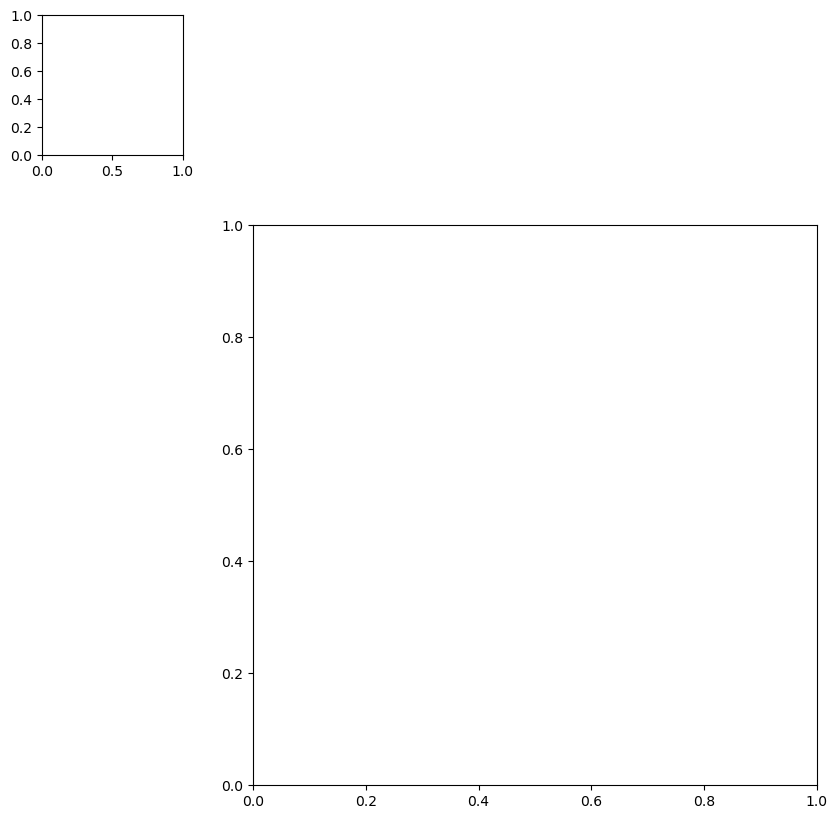

In [4]:
# Create the clustermap
clustermap = sns.clustermap(model.attractor.attractors_df, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.attractor.attractors_df.iloc[row_order, col_order]

# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(reordered_df, 
            #cmap='viridis', 
            vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_AttractorHeatmap.pdf')
plt.show()
plt.close()

From `logic_ensemble` object -> you can define simulation parameters and initial condition of the simulation directly. The simulation gives the node activity at each simulation time that is stored in the object called `.simulation.simulation_df`

# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

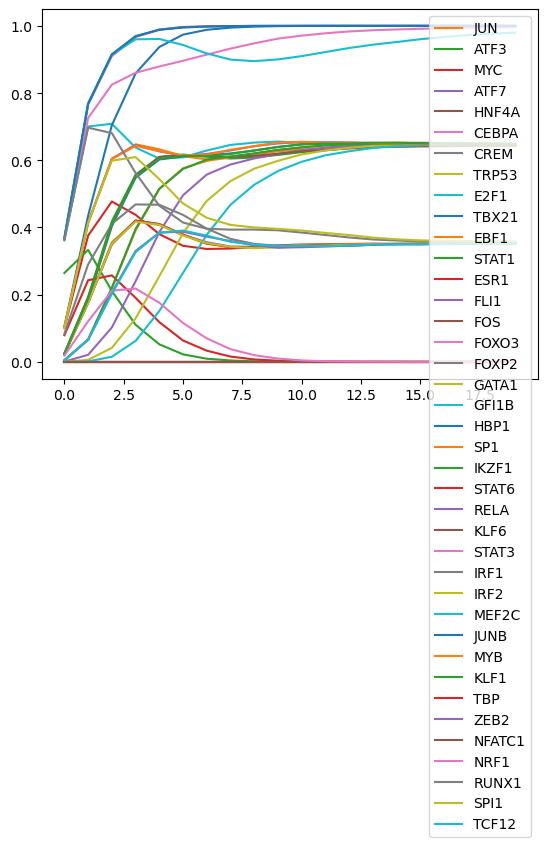

In [5]:
import maboss

test = maboss.bnet_to_maboss(model_path + '/bn0.bnet')
test.update_parameters(time_tick=1, max_time=20)
test_sim = test.run()

test_sim.plot_node_trajectory()

In [7]:
model.simulation.update_parameters(max_time = 20, thread_count = 10, sample_count = 1000)
model.simulation.run_simulation()

Start simulation


100%|██████████| 1000/1000 [11:40<00:00,  1.43it/s]


Simulation completed


In [40]:
model.trajectory.simulation_df.to_csv(model_path + 'hemato_simulation.csv')

Trajectory object created


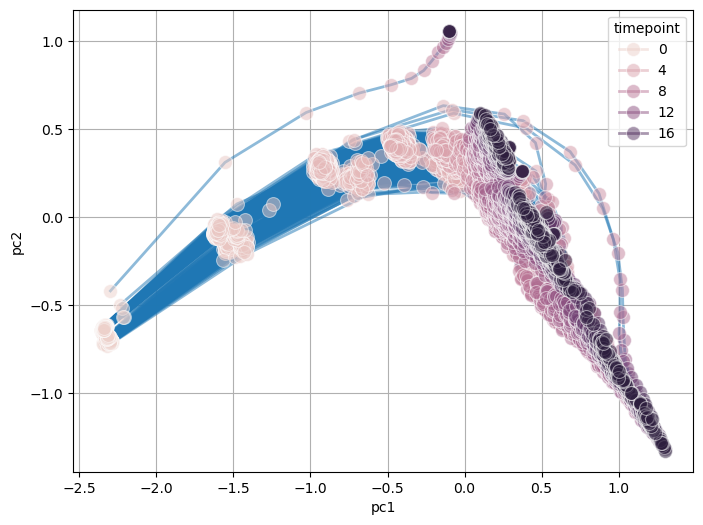

In [8]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [9]:
import numpy as np
# Setup the 
pca_df = model.trajectory.pca_df
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


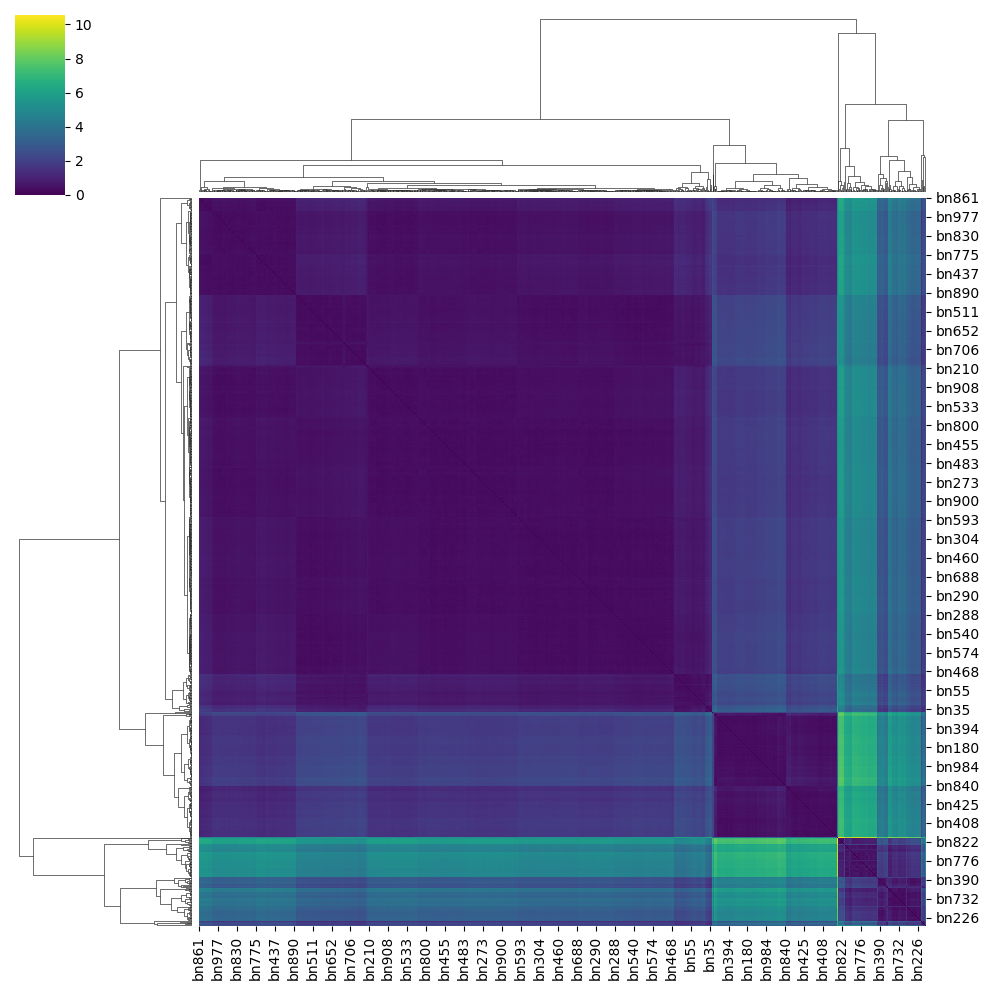

In [10]:
from tslearn.metrics import dtw

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in range(num_trajectories):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_571084/983908655.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


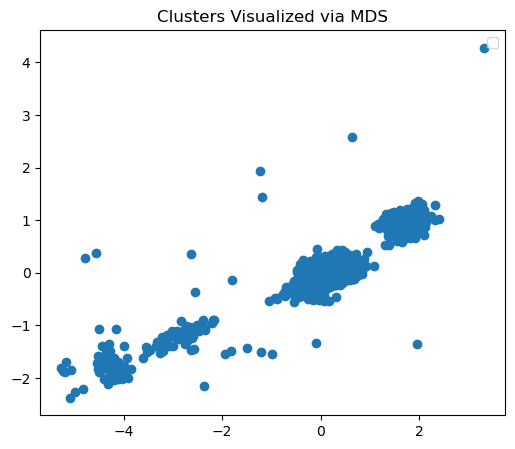

In [11]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1])
plt.legend()
plt.title('Clusters Visualized via MDS')
plt.show()

In [12]:
# Get traj cluster
model.trajectory.calculate_kmean_cluster(n_cluster=3, data = 'original', metric = 'dtw')
cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, cluster_dict_df],axis = 1)

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1

0.569 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s


0.248 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with

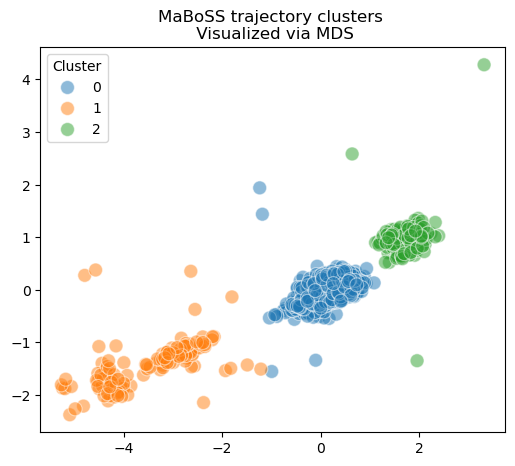

In [13]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='traj_cluster', palette='tab10', alpha=0.5, s=100)
plt.legend(title='Cluster')
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
plt.xlabel(None)
plt.ylabel(None)

plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hemato_trajMDS_cluster.pdf')

plt.show()
plt.close()

Succession diagram object created
Calculating Succession Diagrams


100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


Succession Diagrams calculated


100%|██████████| 1000/1000 [00:05<00:00, 171.38it/s]


Creating SD networks


100%|██████████| 1000/1000 [00:04<00:00, 202.14it/s]


SD networks created


  0%|          | 0/1000 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
100%|██████████| 1000/1000 [16:06<00:00,  1.03it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


SD networks distance calculated


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


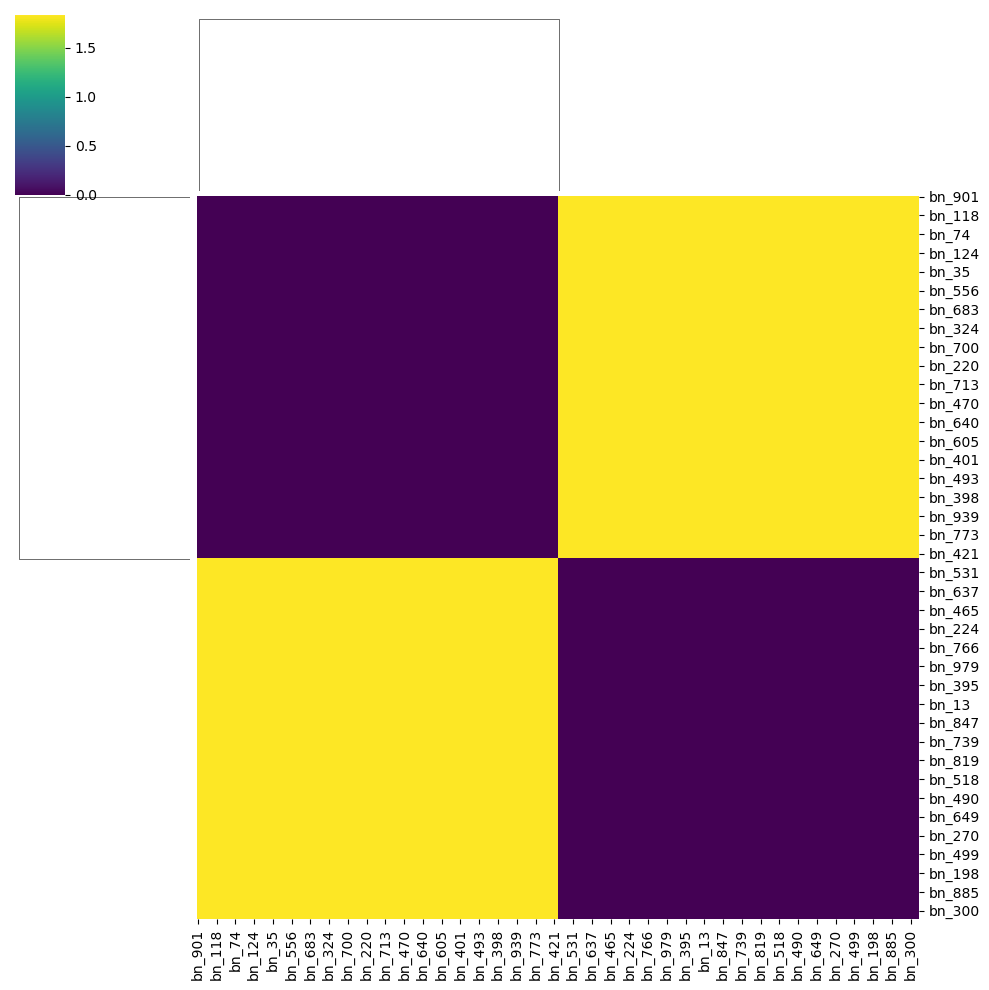

In [20]:
model.create_succession_diagram()
model.succession_diagram.calculate_succession_diagram()
model.succession_diagram.calculate_sd_states()
model.succession_diagram.create_sd_networks()
model.succession_diagram.calculate_sdnet_distance()
sns.clustermap(model.succession_diagram.distance_matrix, cmap='viridis')

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


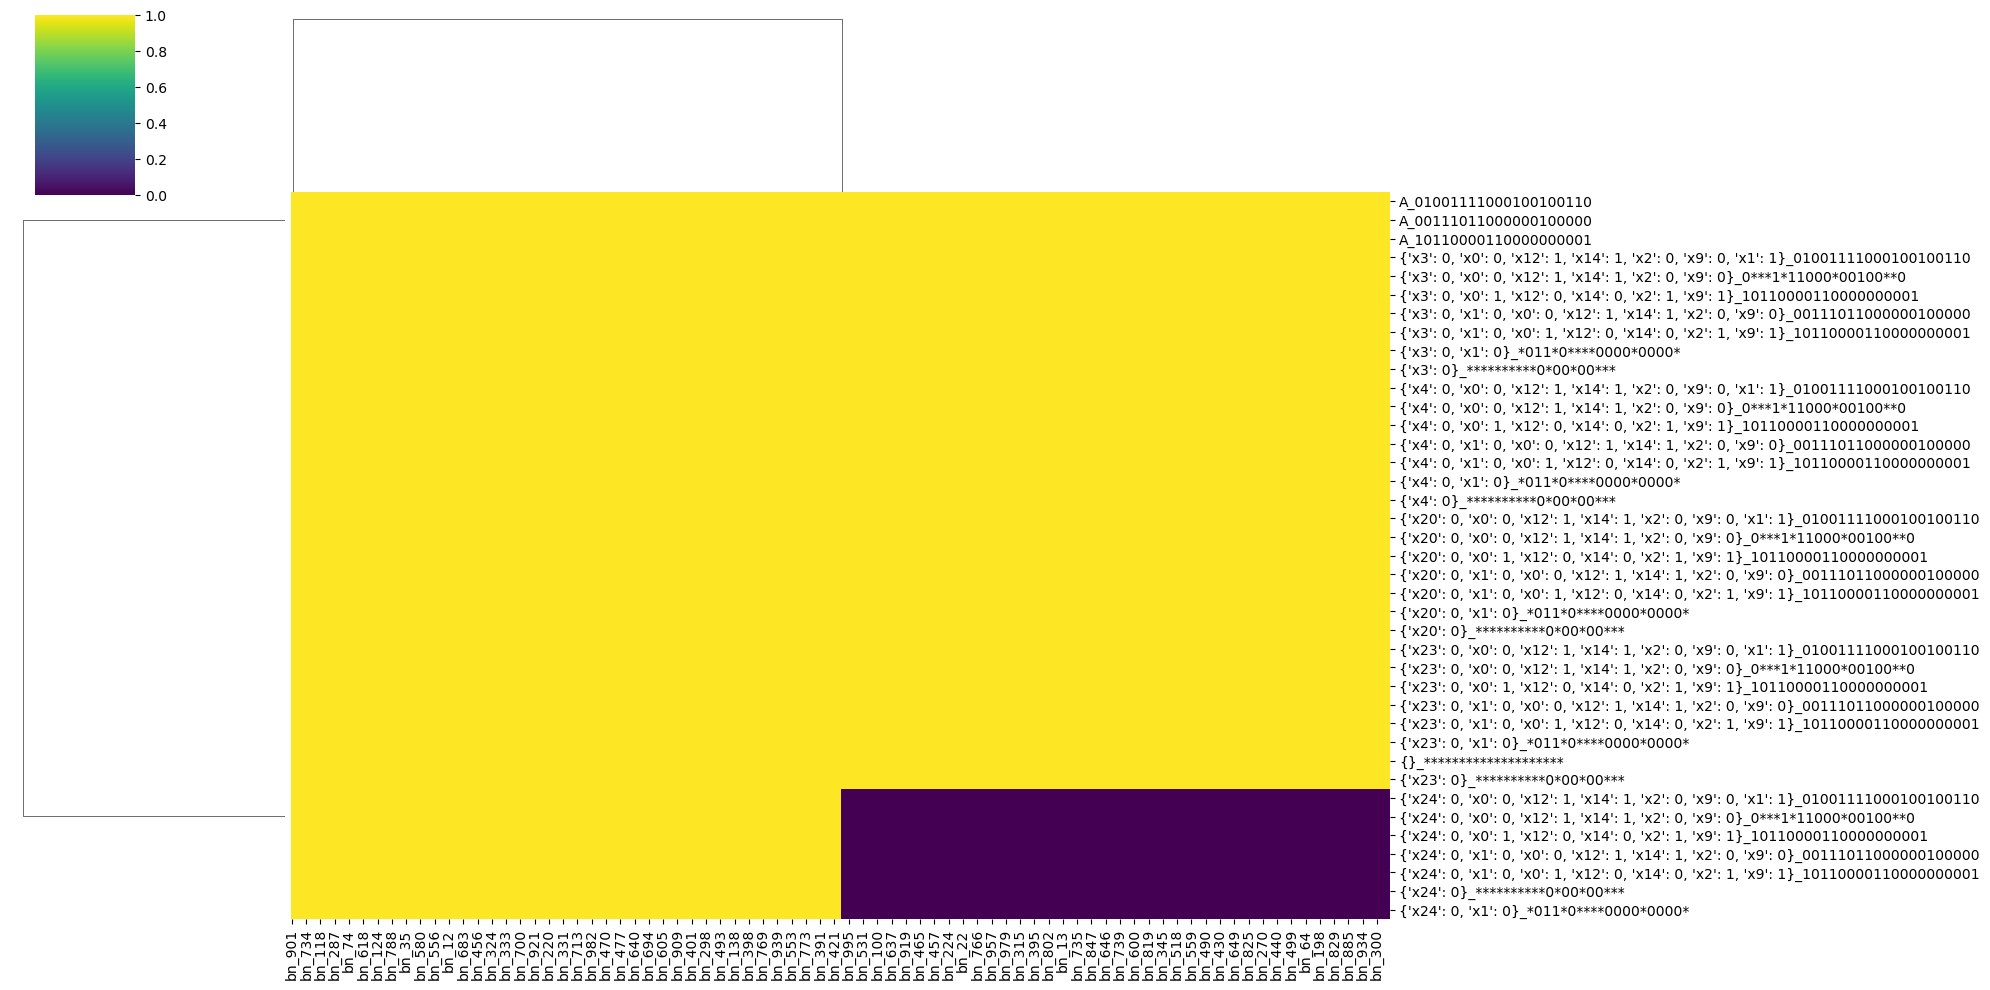

In [ ]:
sns.clustermap(model.succession_diagram.states_bin, figsize=(20,10), cmap='viridis')

/tmp/ipykernel_31654/479990510.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


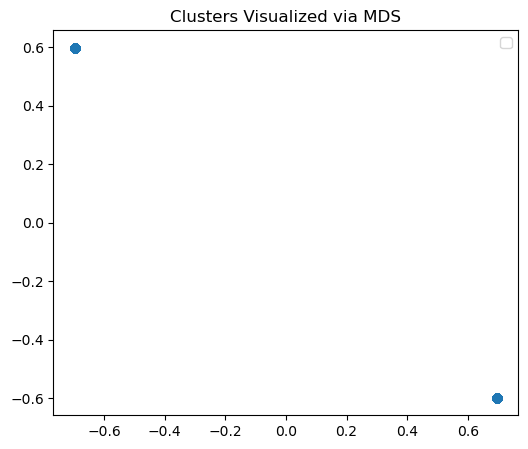

In [21]:
# Visualize clusters with MDS
distance_matrix_2 = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix_2)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1])
plt.legend()
plt.title('Clusters Visualized via MDS')
plt.show()

In [23]:
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape ,dtype = bool), k=1)).stack().reset_index()
distances_1['combined'] = distances_1['level_0'] + "_" + distances_1['level_1']
distances_1.set_index('combined', inplace=True)
distances_1.drop(columns=['level_0', 'level_1'], inplace=True)
distances_1.columns = ['traj_distance']

In [24]:
distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape ,dtype = bool), k=1)).stack().reset_index()
distances_2['combined'] = distances_2['level_0'] + "_" + distances_2['level_1']
distances_2.set_index('combined', inplace=True)
distances_2.drop(columns=['level_0', 'level_1'], inplace=True)
distances_2.columns = ['sd_distance']

Correlation between the two distance matrices: 0.0019898626050284304
P-value: 0.15962333143046728


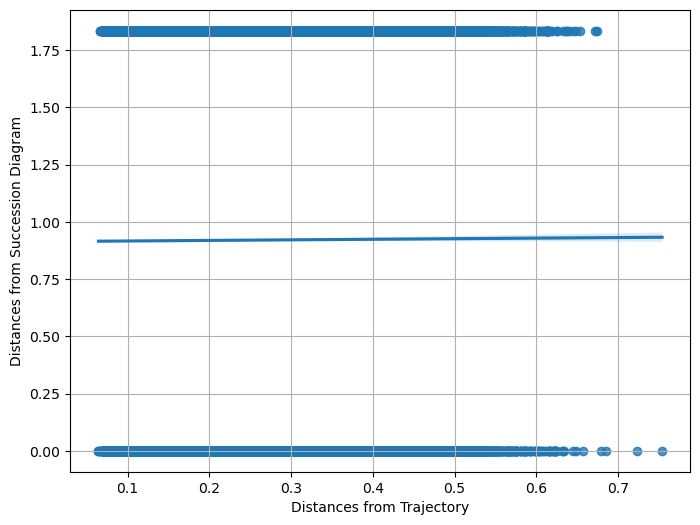

In [25]:
from scipy.stats import pearsonr

# Extract the upper triangular parts of the distance matrices (excluding the diagonal)
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape, dtype = 'bool'), k=1)).stack()

distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape, dtype = 'bool'), k=1)).stack()

# Compute the correlation and p-value
correlation, p_value = pearsonr(distances_1.values, distances_2.values)

# Print the correlation and p-value
print(f"Correlation between the two distance matrices: {correlation}")
print(f"P-value: {p_value}")

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.regplot(x=distances_1.values, y=distances_2.values)
plt.xlabel("Distances from Trajectory")
plt.ylabel("Distances from Succession Diagram")
plt.grid(True)
plt.show()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [14]:
model.create_logic()
model.logic.model_logic

Loading models logics


100%|██████████| 1000/1000 [00:04<00:00, 206.40it/s]


Concatenate results into matrix


100%|██████████| 1000/1000 [00:01<00:00, 623.82it/s]


Logic object created


bn812  \
ATF3    (JUN) | (CREM & KLF6) | (CREM & TRP53) | (KLF6...   
ATF7                                                (MYC)   
CEBPA                                      (HNF4A & !MYC)   
CREM            (FOS & JUN & STAT1) | (JUN & SP1 & STAT1)   
E2F1                                             (!TRP53)   
EBF1                                              (TBX21)   
ESR1    (FOXO3 & SP1 & STAT1) | (FOXO3 & STAT1 & STAT3...   
FLI1                       (EBF1 & MEF2C) | (EBF1 & SPI1)   
FOS     (CREM & ESR1 & SP1 & SPI1 & STAT3 & TRP53) | (...   
FOXO3                                                 (1)   
FOXP2                                                 (1)   
GATA1                                              (FLI1)   
GFI1B                                             (GATA1)   
HBP1                                              (FOXO3)   
HNF4A                    (CEBPA & SP1) | (CEBPA & !TRP53)   
IKZF1                                             (TBX21)   
IRF1    (KLF6 & RELA) | (KLF6 & STAT1) | (KLF6 & STAT3...   
IRF2        (IRF1 & MYC) | (IRF1 & STAT1) | (MYC & STAT1)   
JUN     (E2F1 & ESR1) | (E2F1 & MEF2C) | (ESR1 & MEF2C...   
JUNB                                    (STAT1) | (STAT3)   
KLF1                                                (MYB)   
KLF6                                                (TBP)   
MEF2C                                  (!GFI1B) | (!ZEB2)   
MYB                 (ESR1) | (E2F1 & JUN) | (E2F1 & SPI1)   
MYC     (!CEBPA & E2F1 & !FOS & MYB & RELA & STAT3 & !...   
NFATC1                      (CREM & FOS) | (CREM & MEF2C)   
NRF1                                               (ESR1)   
RELA                                               (E2F1)   
RUNX1   (!ATF3 & !FOXP2) | (!ATF3 & HBP1) | (!FOXP2 & ...   
SP1                                      (CEBPA) | (ESR1)   
SPI1                                      (RUNX1) | (SP1)   
STAT1                                    (!FOXP2 & TRP53)   
STAT3   (SPI1) | (!TRP53) | (!ATF3 & STAT1) | (CEBPA &...   
STAT6                                               (MYC)   
TBP                                               (HNF4A)   
TBX21                                    (RELA) | (STAT1)   
TCF12                                              (ATF7)   
TRP53   (MYC) | (E2F1 & !ESR1 & FOS & STAT1) | (E2F1 &...   
ZEB2                                               (IRF2)   

                                                    bn728  \
ATF3                                                (JUN)   
ATF7                                                (MYC)   
CEBPA                      (HNF4A & MYB) | (HNF4A & !MYC)   
CREM    (FOS & JUN & STAT1) | (FOS & SP1 & STAT1) | (J...   
E2F1    (!TRP53) | (ESR1 & MYC) | (ESR1 & SP1) | (MYC ...   
EBF1                                              (TBX21)   
ESR1    (FOXO3 & SP1 & STAT1) | (FOXO3 & STAT1 & STAT3...   
FLI1                                       (EBF1 & MEF2C)   
FOS     (STAT1) | (!CREM & FLI1 & JUN & SP1) | (ESR1 &...   
FOXO3                                                 (1)   
FOXP2                                                 (1)   
GATA1                                              (FLI1)   
GFI1B                                             (GATA1)   
HBP1                                      (FOXO3) | (MYC)   
HNF4A                                     (CEBPA) | (SP1)   
IKZF1                                             (TBX21)   
IRF1    (KLF6 & STAT1) | (KLF6 & STAT3) | (KLF6 & STAT...   
IRF2                         (IRF1 & MYC) | (MYC & STAT1)   
JUN     (E2F1 & ESR1) | (E2F1 & MEF2C) | (ESR1 & MEF2C...   
JUNB                           (ESR1) | (STAT1) | (STAT3)   
KLF1                                                (MYB)   
KLF6                                                (TBP)   
MEF2C                                  (!GFI1B) | (!ZEB2)   
MYB           (E2F1 & JUN) | (E2F1 & SPI1) | (ESR1 & JUN)   
MYC     (!CEBPA & ESR1 & !TRP53) | (!CEBPA & !FOS & RE...   
NFATC1                   

Flatten models logic clauses


100%|██████████| 1000/1000 [00:00<00:00, 2818752.69it/s]


Concatenate results into matrix


100%|██████████| 1000/1000 [00:01<00:00, 852.74it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Flattend logic clause created


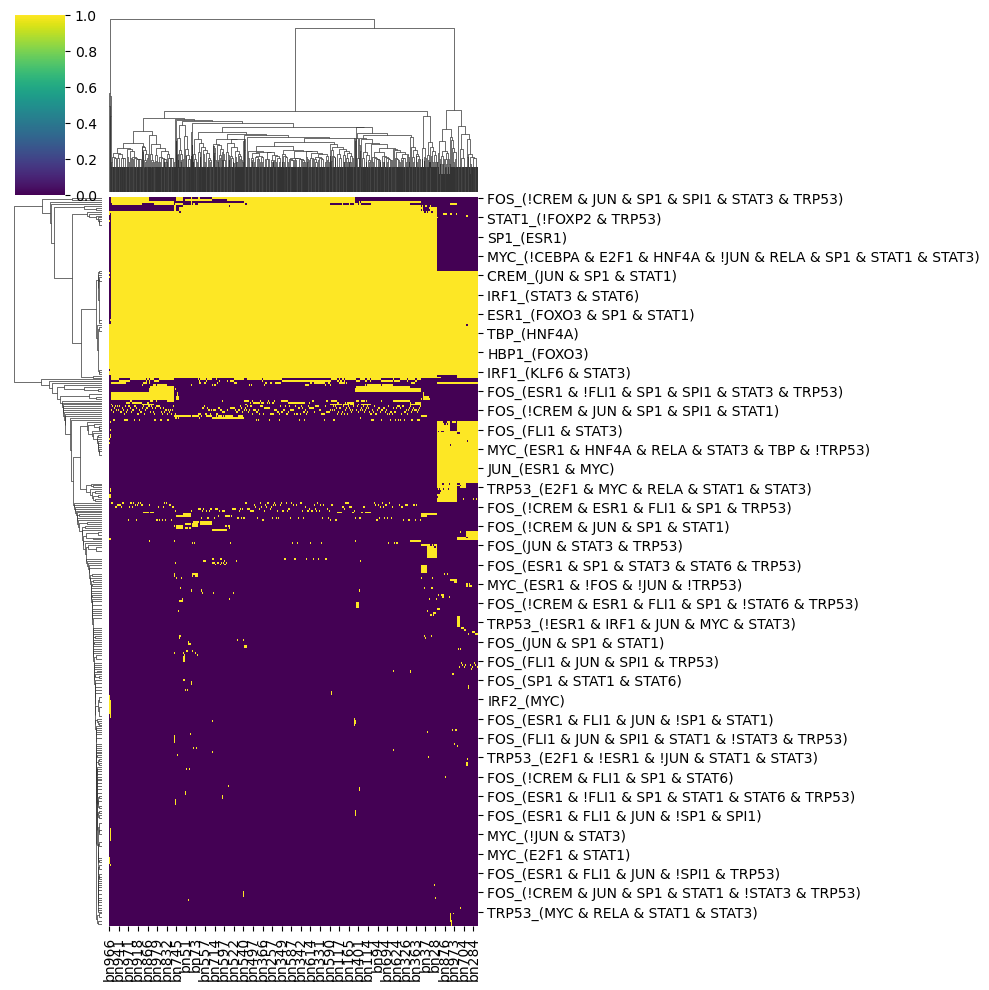

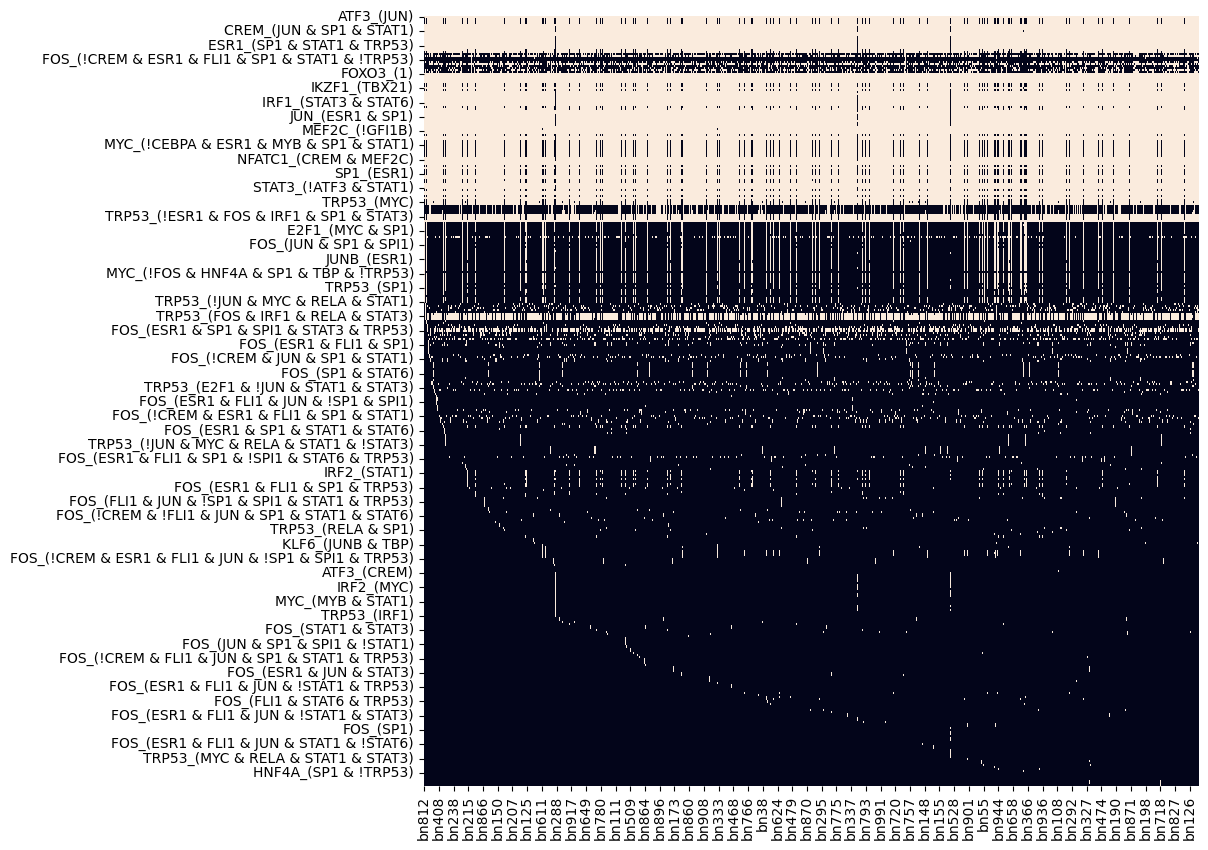

In [15]:
model.logic.create_flattend_logic_clause()
# Create the clustermap
clustermap = sns.clustermap(model.logic.logic_clause_flattend, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.logic.logic_clause_flattend.iloc[row_order, col_order]
# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(model.logic.logic_clause_flattend, vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_Logic.pdf')
plt.show()
plt.close()

In [16]:
model.logic.calculate_logic_pca()

PCA calculated


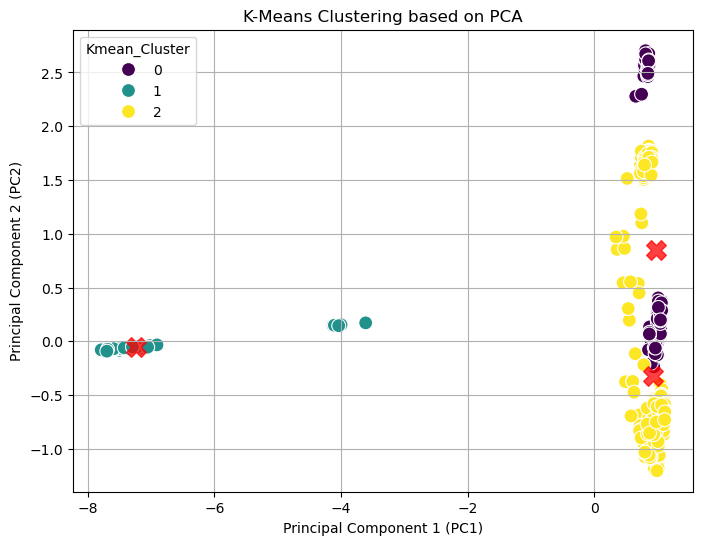

In [17]:
model.logic.calculate_kmean_cluster(num_cluster = 3)

In [18]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(model.logic.pca_df.Kmean_Cluster)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

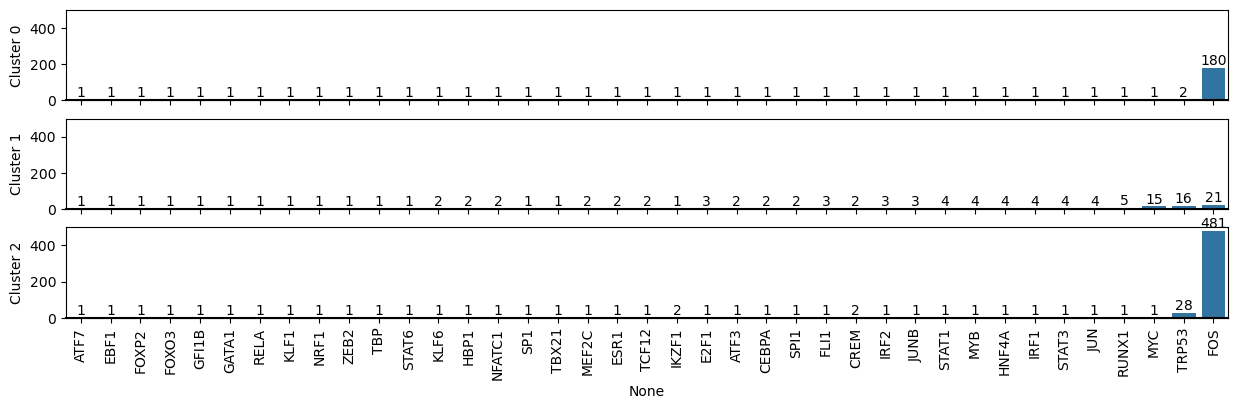

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(15, 4), sharex=True)
plt.ylim(0, 65)

for i in range(3):
    sns.barplot(x=var_logic_clust.index, y=var_logic_clust[i], ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(f"Cluster {i}")
    axes[i].bar_label(axes[i].containers[0], fontsize=10)
    axes[i].set_ylim(0, 500)

plt.xticks(rotation=90)
plt.show()

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


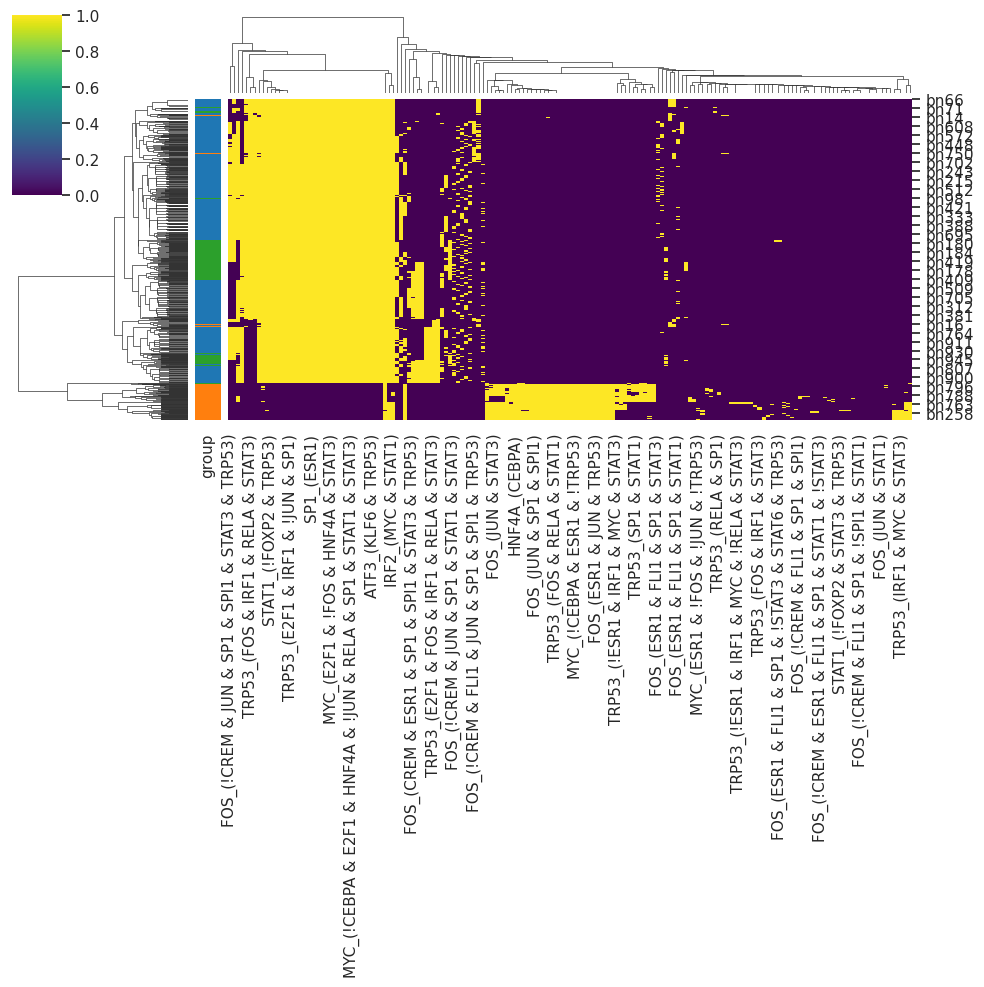

In [32]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[marker_features], cmap='viridis', figsize=(10, 10), row_colors=group_colors)

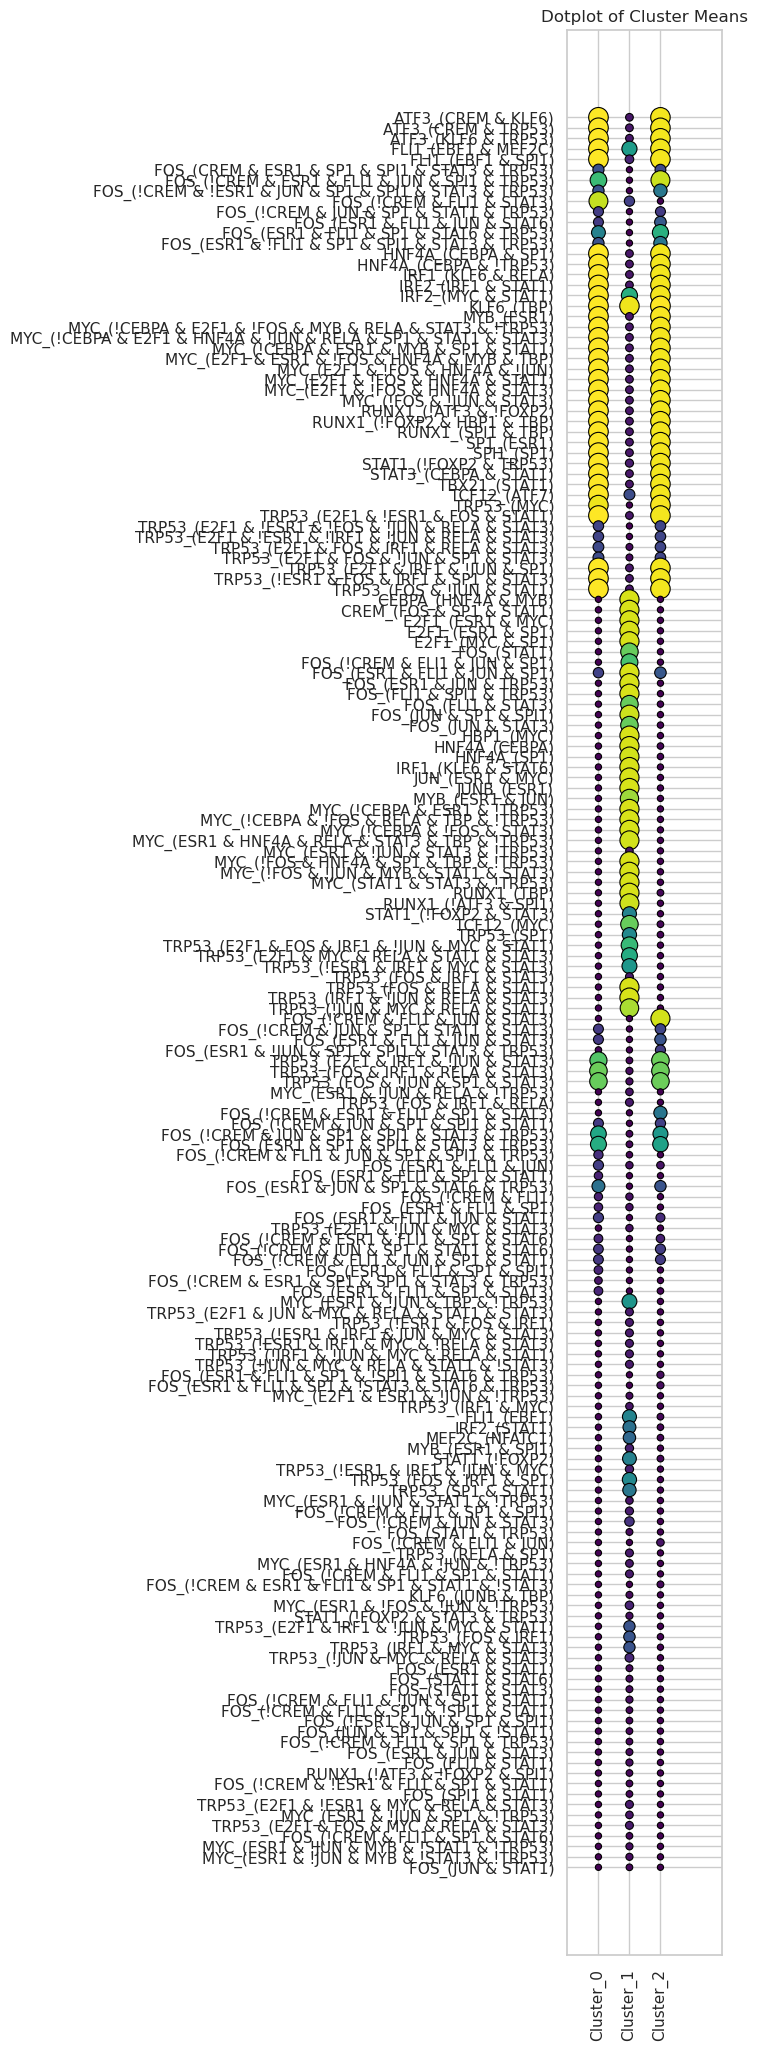

In [27]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean

# Convert the result_df to a long format for easier plotting with seaborn
result_df = result_df.loc[marker_features,:]
result_long_df = result_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')

# Create the dot plot
plt.figure(figsize=(2, 25))
sns.set_theme(style="whitegrid")
dotplot = sns.scatterplot(data=result_long_df, 
                          x=pd.Categorical(result_long_df['Cluster'], categories=['Cluster_0', 'Cluster_1','Cluster_2'], ordered=True), 
                          y='index', 
                          size='Value', hue='Value', 
                          palette='viridis', sizes=(20, 200), legend=None,
                          edgecolor='black', linewidth=0.8)

# Customize the plot
plt.title('Dotplot of Cluster Means')
#plt.xlabel('Cluster')
plt.ylabel(None)
plt.xticks(rotation=90)
plt.xlim(-1,4)
#plt.savefig('/home/spankaew/Git/astrologics/figures/hh_traj_dotplot.pdf', bbox_inches='tight')

plt.show()
plt.close()

ATF3_(JUN)  ATF3_(CREM & KLF6)  ATF3_(CREM & TRP53)  \
bn812         1.0                 1.0                  1.0   
bn168         1.0                 1.0                  1.0   
bn157         1.0                 1.0                  1.0   
bn639         1.0                 1.0                  1.0   
bn45          1.0                 1.0                  1.0   
...           ...                 ...                  ...   
bn979         1.0                 1.0                  1.0   
bn200         1.0                 1.0                  1.0   
bn356         1.0                 1.0                  1.0   
bn364         1.0                 1.0                  1.0   
bn504         1.0                 1.0                  1.0   

       ATF3_(KLF6 & TRP53)  ATF7_(MYC)  CEBPA_(HNF4A & !MYC)  \
bn812                  1.0         1.0                   1.0   
bn168                  1.0         1.0                   1.0   
bn157                  1.0         1.0                   1.0   
bn639                  1.0         1.0                   1.0   
bn45                   1.0         1.0                   1.0   
...                    ...         ...                   ...   
bn979                  1.0         1.0                   1.0   
bn200                  1.0         1.0                   1.0   
bn356                  1.0         1.0                   1.0   
bn364                  1.0         1.0                   1.0   
bn504                  1.0         1.0                   1.0   

       CREM_(FOS & JUN & STAT1)  CREM_(JUN & SP1 & STAT1)  E2F1_(!TRP53)  \
bn812                       1.0                       1.0            1.0   
bn168                       1.0                       1.0            1.0   
bn157                       1.0                       1.0            1.0   
bn639                       1.0                       1.0            1.0   
bn45                        1.0                       1.0            1.0   
...                         ...                       ...            ...   
bn979                       1.0                       1.0            1.0   
bn200                       1.0                       1.0            1.0   
bn356                       1.0                       1.0            1.0   
bn364                       1.0                       1.0            1.0   
bn504                       1.0                       1.0            1.0   

       EBF1_(TBX21)  ESR1_(FOXO3 & SP1 & STAT1)  ESR1_(FOXO3 & STAT1 & STAT3)  \
bn812           1.0                         1.0                           1.0   
bn168           1.0                         1.0                           1.0   
bn157           1.0                         1.0                           1.0   
bn639           1.0                         1.0                           1.0   
bn45            1.0                         1.0                           1.0   
...             ...                         ...                           ...   
bn979           1.0                         1.0                           1.0   
bn200           1.0                         1.0                           1.0   
bn356           1.0                         1.0                           1.0   
bn364           1.0                         1.0                           1.0   
bn504           1.0                         1.0                           1.0   

       ESR1_(FOXO3 & STAT1 & TRP53)  ESR1_(SP1 & STAT1 & STAT3)  \
bn812                           1.0                         1.0   
bn168                           1.0                         1.0   
bn157                           1.0                         1.0   
bn639                           1.0                         1.0   
bn45                            1.0                         1.0   
...                             ...                         ...   
bn979                           1.0                         1.0   
bn200                           1.0                         1.0   
bn35

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


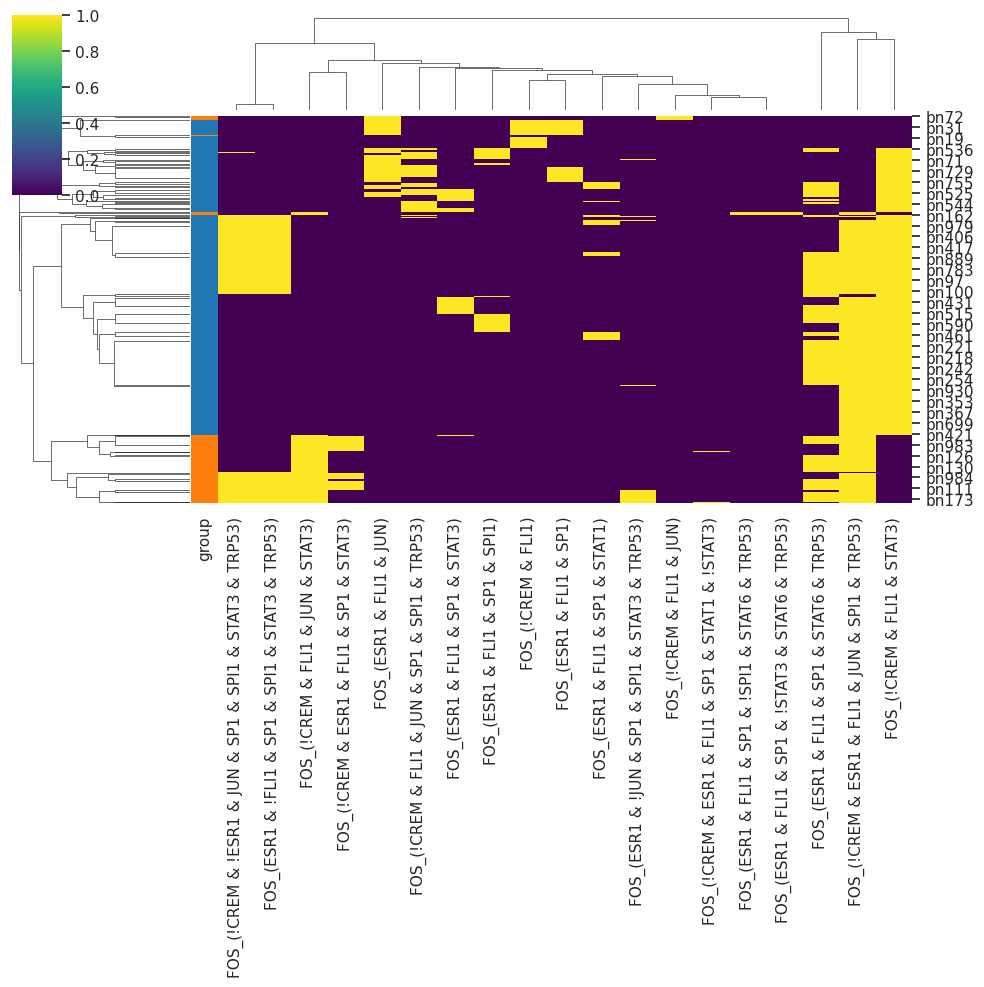

In [38]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
test = test.loc[test['group'].isin([0,2])]
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[marker_features], cmap='viridis', figsize=(10, 10), row_colors=group_colors)

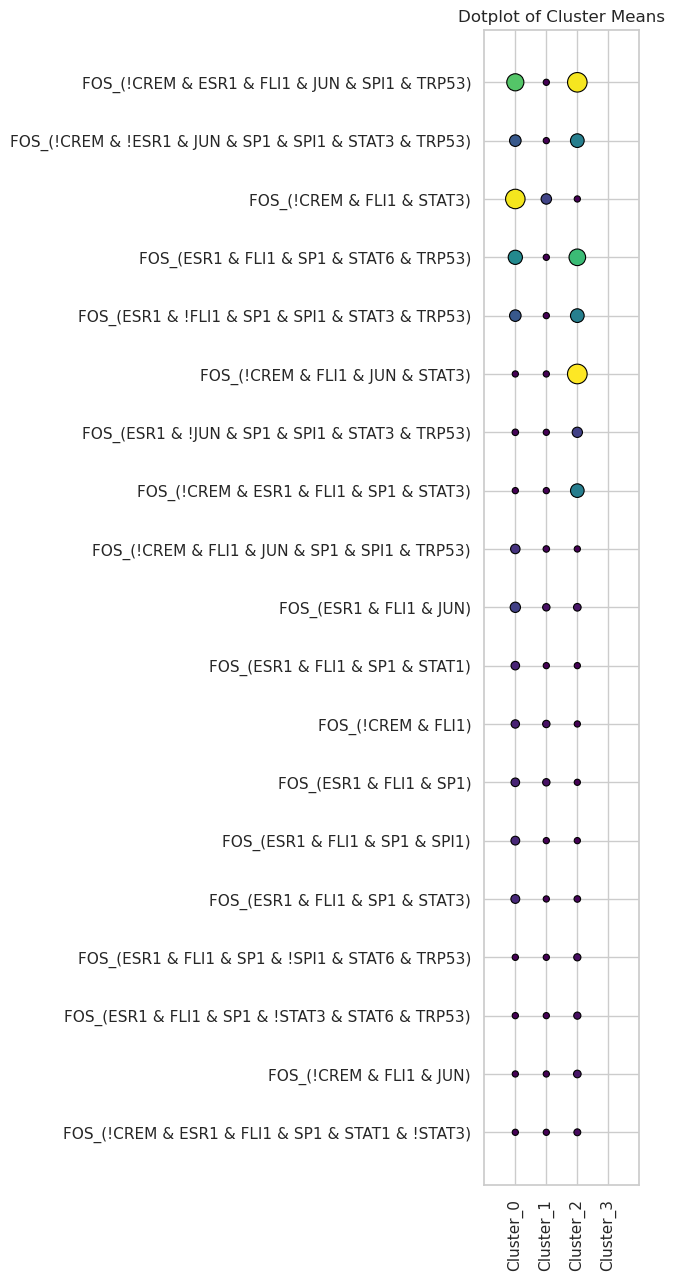

In [39]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean

# Convert the result_df to a long format for easier plotting with seaborn
result_df = result_df.loc[marker_features,:]
result_long_df = result_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')

# Create the dot plot
plt.figure(figsize=(2, 15))
sns.set_theme(style="whitegrid")
dotplot = sns.scatterplot(data=result_long_df, 
                          x=pd.Categorical(result_long_df['Cluster'], categories=['Cluster_0', 'Cluster_1','Cluster_2','Cluster_3'], ordered=True), 
                          y='index', 
                          size='Value', hue='Value', 
                          palette='viridis', sizes=(20, 200), legend=None,
                          edgecolor='black', linewidth=0.8)

# Customize the plot
plt.title('Dotplot of Cluster Means')
#plt.xlabel('Cluster')
plt.ylabel(None)
plt.xticks(rotation=90)
plt.xlim(-1,4)
#plt.savefig('/home/spankaew/Git/astrologics/figures/hh_traj_dotplot.pdf', bbox_inches='tight')

plt.show()
plt.close()

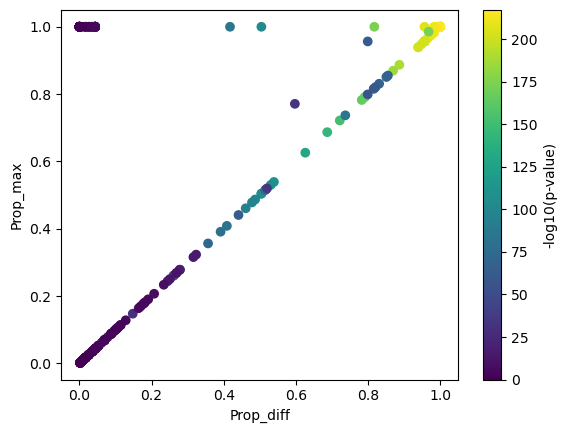

In [123]:
chi2_results['-log10(p-value)'] = -np.log10(chi2_results['p-value'])
plt.scatter(x=chi2_results['Prop_diff'], 
            y=chi2_results['Prop_max'], 
            c=chi2_results['-log10(p-value)'], 
            cmap='viridis')
plt.colorbar(label='-log10(p-value)')
plt.xlabel('Prop_diff')
plt.ylabel('Prop_max')
plt.show()

In [97]:
chi2_results['Prop_diff'] = abs(chi2_results['Prop_max_act'] - chi2_results['Prop_min_act'])
chi2_results

Chi-Square Statistic  \
IRF2_(IRF1 & STAT1)                                            990.19854   
MYC_(!FOS & !JUN & STAT3)                                      990.19854   
MYC_(!CEBPA & E2F1 & HNF4A & !JUN & RELA & SP1 ...             990.19854   
RUNX1_(!FOXP2 & HBP1 & TBP)                                    990.19854   
RUNX1_(SPI1 & TBP)                                             990.19854   
...                                                                  ...   
ATF7_(MYC)                                                       0.00000   
FOS_(CREM & ESR1 & SP1 & STAT1 & STAT6 & TRP53)                  0.00000   
FOS_(ESR1 & SP1 & STAT1 & !STAT3 & STAT6 & TRP53)                0.00000   
FOS_(ESR1 & SP1 & !SPI1 & STAT1 & STAT6 & TRP53)                 0.00000   
ATF3_(JUN)                                                       0.00000   

                                                          p-value  \
IRF2_(IRF1 & STAT1)                                 2.425272e-217   
MYC_(!FOS & !JUN & STAT3)                           2.425272e-217   
MYC_(!CEBPA & E2F1 & HNF4A & !JUN & RELA & SP1 ...  2.425272e-217   
RUNX1_(!FOXP2 & HBP1 & TBP)                         2.425272e-217   
RUNX1_(SPI1 & TBP)                                  2.425272e-217   
...                                                           ...   
ATF7_(MYC)                                           1.000000e+00   
FOS_(CREM & ESR1 & SP1 & STAT1 & STAT6 & TRP53)      1.000000e+00   
FOS_(ESR1 & SP1 & STAT1 & !STAT3 & STAT6 & TRP53)    1.000000e+00   
FOS_(ESR1 & SP1 & !SPI1 & STAT1 & STAT6 & TRP53)     1.000000e+00   
ATF3_(JUN)                                           1.000000e+00   

                                                    Prop_min_act  \
IRF2_(IRF1 & STAT1)                                          0.0   
MYC_(!FOS & !JUN & STAT3)                                    0.0   
MYC_(!CEBPA & E2F1 & HNF4A & !JUN & RELA & SP1 ...           0.0   
RUNX1_(!FOXP2 & HBP1 & TBP)                                  0.0   
RUNX1_(SPI1 & TBP)                                           0.0   
...                                                          ...   
ATF7_(MYC)                                                   1.0   
FOS_(CREM & ESR1 & SP1 & STAT1 & STAT6 & TRP53)              0.0   
FOS_(ESR1 & SP1 & STAT1 & !STAT3 & STAT6 & TRP53)            0.0   
FOS_(ESR1 & SP1 & !SPI1 & STAT1 & STAT6 & TRP53)             0.0   
ATF3_(JUN)                                                   1.0   

                                                    Prop_max_act  Prop_diff  
IRF2_(IRF1 & STAT1)                                      1.00000    1.00000  
MYC_(!FOS & !JUN & STAT3)                                1.00000    1.00000  
MYC_(!CEBPA & E2F1 & HNF4A & !JUN & RELA & SP1 ...       1.00000    1.00000  
RUNX1_(!FOXP2 & HBP1 & TBP)                              1.00000    1.00000  
RUNX1_(SPI1 & TBP)                                       1.00000    1.00000  
...                                                          ...        ...  
ATF7_(MYC)                                               1.00000    0.00000  
FOS_(CREM & ESR1 & SP1 & STAT1 & STAT6 & TRP53)          0.00226    0.00226  
FOS_(ESR1 & SP1 & STAT1 & !STAT3 & STAT6 & TRP53)        0.00226    0.00226  
FOS_(ESR1 & SP1 & !SPI1 & STAT1 & STAT6 & TRP53)         0.00113    0.00113  
ATF3_(JUN)                                               1.00000    0.00000  

[378 rows x 5 columns]

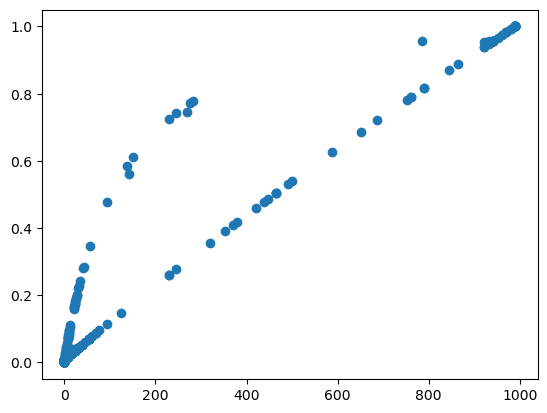

In [101]:
plt.scatter(x = chi2_results['Chi-Square Statistic'], 
            y = chi2_results['Prop_diff'])

In [26]:
from sklearn.preprocessing import OrdinalEncoder

In [28]:
model_cluster = pd.Series(model.logic.pca_df.Kmean_Cluster)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

In [30]:
var_logic_clust

1   0
ATF7      1   1
EBF1      1   1
FOXP2     1   1
FOXO3     1   1
GFI1B     1   1
GATA1     1   1
RELA      1   1
KLF1      1   1
NRF1      1   1
ZEB2      1   1
TBP       1   1
STAT6     1   1
KLF6      1   2
HBP1      1   2
NFATC1    1   2
SP1       1   1
TBX21     1   1
MEF2C     1   2
ESR1      1   2
TCF12     1   2
IKZF1     2   1
E2F1      1   3
ATF3      1   2
CEBPA     1   2
SPI1      1   2
FLI1      1   3
CREM      2   2
IRF2      1   3
JUNB      1   3
STAT1     1   4
MYB       1   4
HNF4A     1   4
IRF1      1   4
STAT3     1   4
JUN       1   4
RUNX1     1   5
MYC       1  15
TRP53    28  16
FOS     661  21

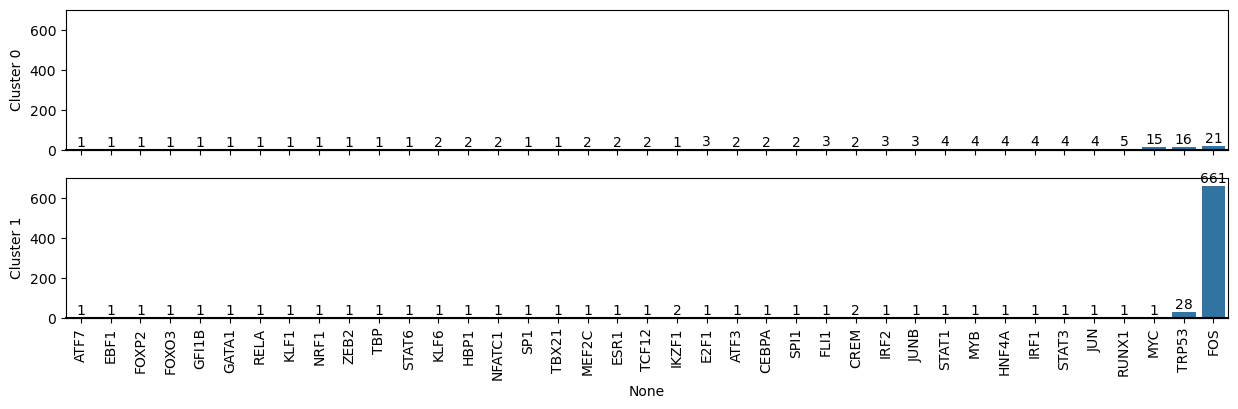

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
plt.ylim(0, 65)

for i in range(2):
    sns.barplot(x=var_logic_clust.index, y=var_logic_clust[i], ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(f"Cluster {i}")
    axes[i].bar_label(axes[i].containers[0], fontsize=10)
    axes[i].set_ylim(0, 700)

plt.xticks(rotation=90)
plt.show()